In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
# 데이터를 엑세스하기 위한 h5py
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import zipfile
import imageio
import os

# pytorch 패키지 다운
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [3]:
if torch.cuda.is_available():
   torch.set_default_tensor_type(torch.cuda.FloatTensor)
   print('using cuda:', torch.cuda.get_device_name(0))


using cuda: Tesla T4


In [4]:
# CelebA의 이미지 파일을 다운로드합니다
import torchvision.datasets
mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
# 이미지를 2만장으로 추립니다.
# 시간 주의 
%%time
hdf5_file = '/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py'
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('/content/celeba/img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass
     

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: user 2min 44s, sys: 11.4 s, total: 2min 55s
Wall time: 3min 33s


In [6]:
with h5py.File('/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py', 'r') as file_object:
   for group in file_object:
      print(group)
      pass

img_align_celeba


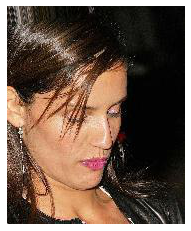

In [7]:
# 파일 하나만 꺼내보기 (3번)
with h5py.File('/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py', 'r') as file_object:
    dataset=file_object['img_align_celeba']
    image = np.array(dataset['3.jpg'])
    plt.imshow(image, interpolation = 'none')
    plt.axis('off')

In [8]:
class CelebADataset(Dataset):
     def __init__(self, file):
         self.file_object = h5py.File(file, 'r')
         self.dataset = self.file_object['img_align_celeba']
         pass
     def __len(self):
         return len(self.dataset)
     def __getitem__(self, index):
         if (index >= len(self.dataset)):
            raise IndexError()
         img = np.array(self.dataset[str(index)+'.jpg'])
         return torch.cuda.FloatTensor(img) / 255.0

     def plot_image(self, index):
         plt.imshow(np.array(self.dataset[str(index)+'.jpg']),
                    interpolation = 'nearest')
         pass
     pass 

In [9]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [10]:
x = generate_random_image(2)
print(x.device)
y = generate_random_seed(2)
print(y.device)

cuda:0
cuda:0


In [11]:
celeba_dataset = CelebADataset('/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py')

In [12]:
# gpu 사용

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# 판별자

# view = 3차원을 1차원으로 펴줍니다
class View(nn.Module):
   def __init__(self, shape):
       super().__init__()
       self.shape = shape,

   def forward(self, x):
       return x.view(*self.shape)

class Discriminator(nn.Module):
   def __init__(self):
       super().__init__()
       self.model = nn.Sequential(
           View(218*178*3),
           nn.Linear(3*218*178,100),
           nn.LeakyReLU(),
           nn.LayerNorm(100),
           nn.Linear(100,1),
           nn.Sigmoid()
       )
       self.loss_function = nn.MSELoss()
       self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)
       self.counter = 0;
       self.progress = []

   def forward(self, inputs):
        return self.model(inputs)
    
    
   def train(self, inputs, targets):
       outputs = self.forward(inputs)
        
       loss = self.loss_function(outputs, targets)

       self.counter += 1;
       if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
       if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass


       self.optimiser.zero_grad()
       loss.backward()
       self.optimiser.step()

       pass
    
    
   def plot_progress(self):
       df = pd.DataFrame(self.progress, columns=['loss'])
       df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
       pass
    
   pass

In [14]:
# discriminator 시간 체크
# 시간 주의 2분 17초
%%time
D = Discriminator()
D.to(device)
for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 2min 7s, sys: 4.42 s, total: 2min 12s
Wall time: 2min 18s


In [15]:
class Generator(nn.Module):
    
    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()      
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [16]:
G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=300, out_features=116412, bias=True)
    (4): Sigmoid()
    (5): View()
  )
)

In [17]:
generate_random_seed(100)

tensor([-0.3745, -1.0083, -0.5486,  0.7030, -1.2538, -0.6290,  0.5972, -0.0522,
        -0.4524,  0.4844, -0.3721, -0.5775, -0.0818, -0.3396, -0.5041,  1.1872,
         0.4919, -0.1095, -1.1177,  0.7384,  0.4562, -1.5767, -0.6636,  0.9821,
        -2.1884, -0.2757,  2.0964, -0.3632, -0.0273,  1.1847,  1.3075,  0.5667,
        -0.3406, -1.9271,  0.1942,  0.4581,  0.5864, -0.7324,  2.8893, -2.1179,
        -0.3465,  0.2115, -0.9823, -0.9384,  1.2420, -0.4894, -1.5906, -0.2015,
        -2.2040,  0.1067, -0.3557,  1.1294, -0.5059, -0.7698,  0.9567, -0.4081,
        -0.9133,  0.6990, -1.3379, -1.3436, -0.6813, -0.0148, -1.1324, -0.7160,
        -0.5473, -0.4445,  0.7013,  0.6860,  0.8022, -0.1604,  0.6192, -0.0891,
        -0.5877, -0.4558, -0.0576,  2.1926,  0.5391, -1.1756, -0.0197, -0.5584,
         0.1833, -1.4689, -0.5616,  1.1415,  1.0583,  0.3825, -0.1952,  0.0130,
         0.1528, -1.4181, -0.9657,  1.9692,  0.5961,  0.5432,  0.5566, -0.5952,
        -1.4550, -1.1718,  0.5834, -0.38

## cmap의 종류
> 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean'

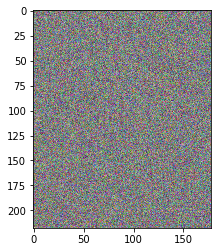

In [18]:
output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap = 'copper')

In [19]:
%%time
# 시간 주의
# 다시 성공한듯? 에포크 3회에 약 27분
EPOCHS = 3 # 1회에서 잘못 돌림. 3회로 다시 시도

for epoch in range(EPOCHS):
  print(f' 에포크 = {epoch+1}')

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass
  pass    

 에포크 = 1
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counter =  60000
counter =  61000
counter =  62000
counter =  63000
counter =  64000
counter =  65000
counter =  66000
counter =  67000
counter =  68000
counter =  69000
counter =  70000
counter =  71000
counter =  72000
counter =  73000
counter =  74000
counter =  75000
counter =  76000
counter =  77000
counter =  78000
counter =  79000
counter =  80000
 에포크 = 2
counter =  81000
counter =  82000
counter =  83000
counter =  84000
counter =  85000
counter =  86000
counter =  87000
counter =  88000
counter =  89000
counter =  90000
counter =  91000
counter =  92000
counter =  93000
counter =  94000
counter =  95000
counter =  96000
counter =  97000
counter =  98

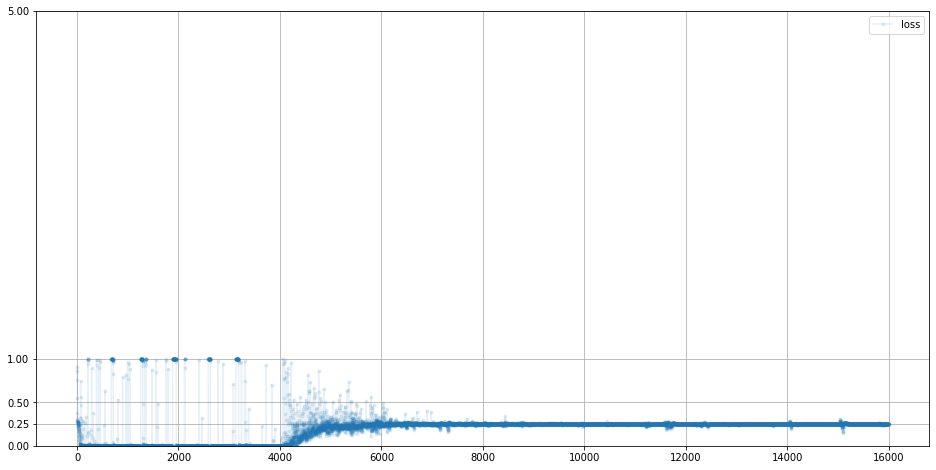

In [20]:
D.plot_progress()

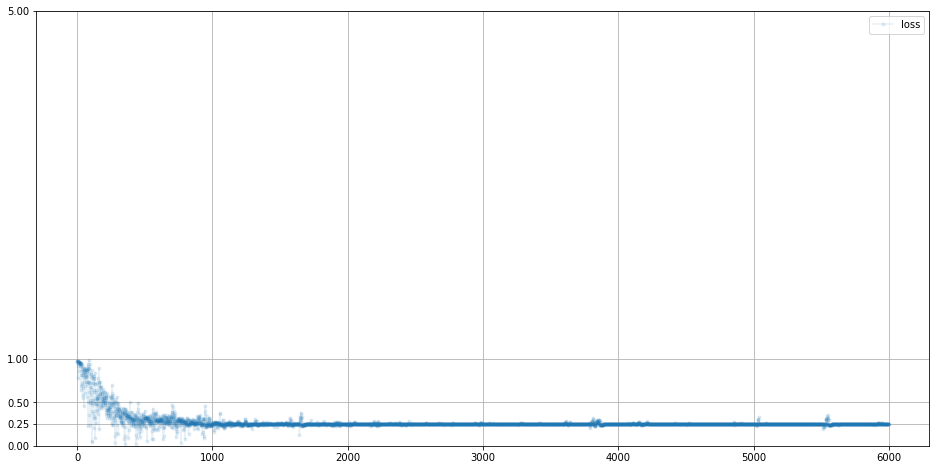

In [21]:
G.plot_progress()

In [22]:
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=300, out_features=116412, bias=True)
    (4): Sigmoid()
    (5): View()
  )
)

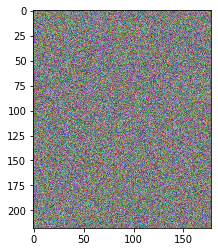

In [23]:
output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap = 'copper')

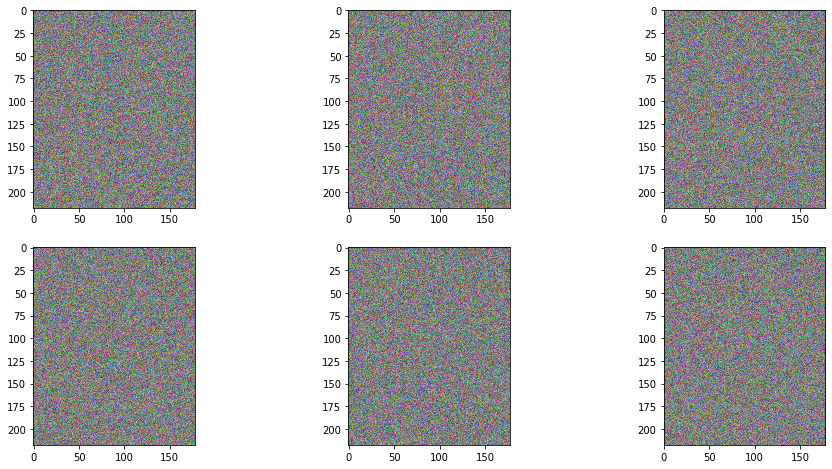

In [24]:
# 조짐이 좋다고 함
# subplot을 사용해서 더 많이 이미지 조회

f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

# 실패 후 재시작


* 에포크 1회부터 다시 시작

In [29]:
%%time
# 시간 주의
EPOCHS = 1

for epoch in range(EPOCHS):
    print(f' 에포크 = {epoch+1}')

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass
pass    

 에포크 = 1
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counter =  60000
counter =  61000
counter =  62000
counter =  63000
counter =  64000
counter =  65000
counter =  66000
counter =  67000
counter =  68000
counter =  69000
counter =  70000
counter =  71000
counter =  72000
counter =  73000
counter =  74000
counter =  75000
counter =  76000
counter =  77000
counter =  78000
counter =  79000
counter =  80000
CPU times: user 8min 48s, sys: 4.23 s, total: 8min 52s
Wall time: 9min 5s


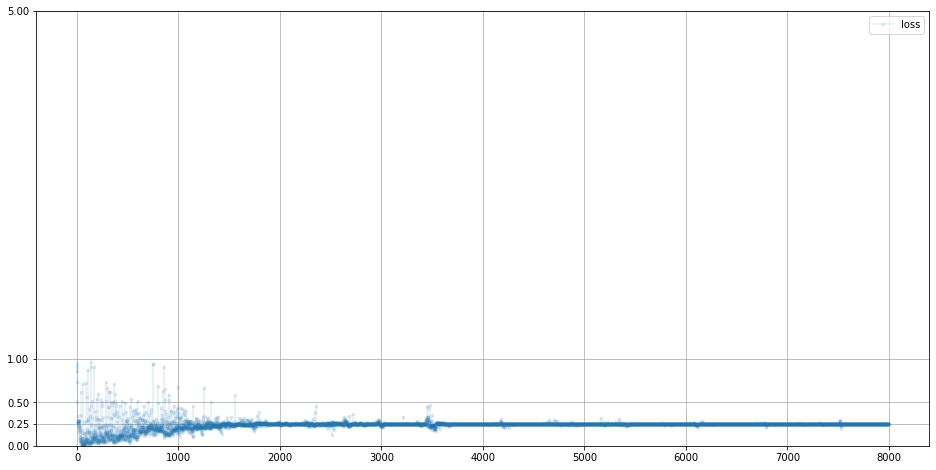

In [30]:
D.plot_progress()

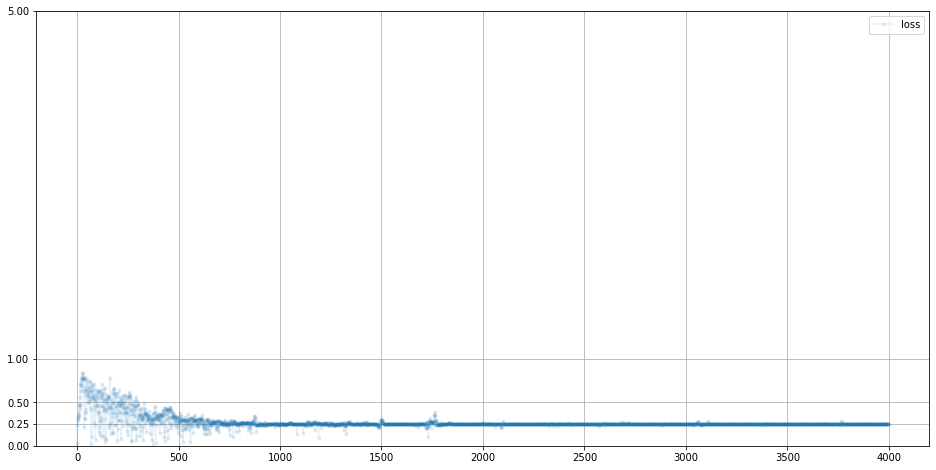

In [31]:
G.plot_progress()

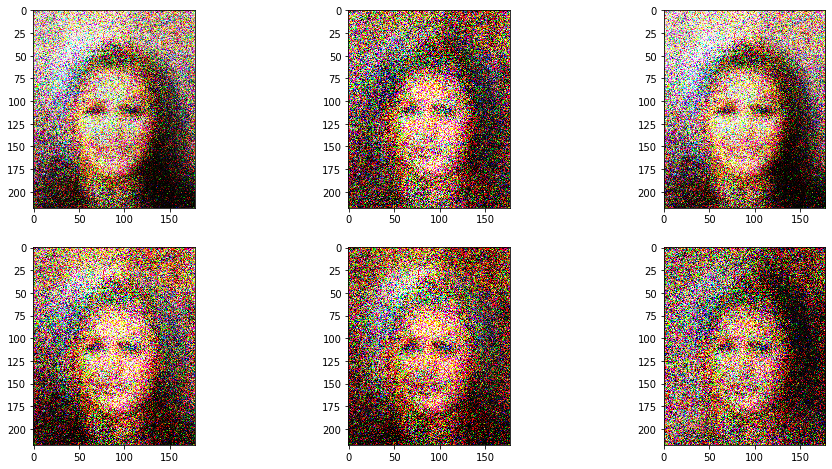

In [32]:
f, axarr = plt.subplots(2,3, figsize = (16, 8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation = 'none', cmap = 'Blues')
        pass
    pass

# epoch 2회

In [33]:
%%time
# 시간 주의
# 다시 성공한듯? 에포크 2회에 ??
EPOCHS = 2 # 1회에서 잘못 돌림. 3회로 다시 시도

for epoch in range(EPOCHS):
  print(f' 에포크 = {epoch+1}')

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass
  pass    

 에포크 = 1
counter =  81000
counter =  82000
counter =  83000
counter =  84000
counter =  85000
counter =  86000
counter =  87000
counter =  88000
counter =  89000
counter =  90000
counter =  91000
counter =  92000
counter =  93000
counter =  94000
counter =  95000
counter =  96000
counter =  97000
counter =  98000
counter =  99000
counter =  100000
counter =  101000
counter =  102000
counter =  103000
counter =  104000
counter =  105000
counter =  106000
counter =  107000
counter =  108000
counter =  109000
counter =  110000
counter =  111000
counter =  112000
counter =  113000
counter =  114000
counter =  115000
counter =  116000
counter =  117000
counter =  118000
counter =  119000
counter =  120000
 에포크 = 2
counter =  121000
counter =  122000
counter =  123000
counter =  124000
counter =  125000
counter =  126000
counter =  127000
counter =  128000
counter =  129000
counter =  130000
counter =  131000
counter =  132000
counter =  133000
counter =  134000
counter =  135000
counter =  

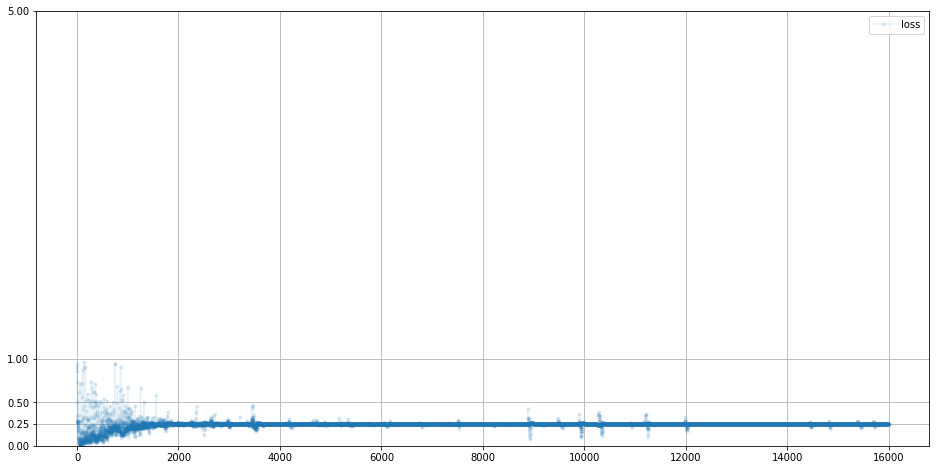

In [34]:
D.plot_progress()

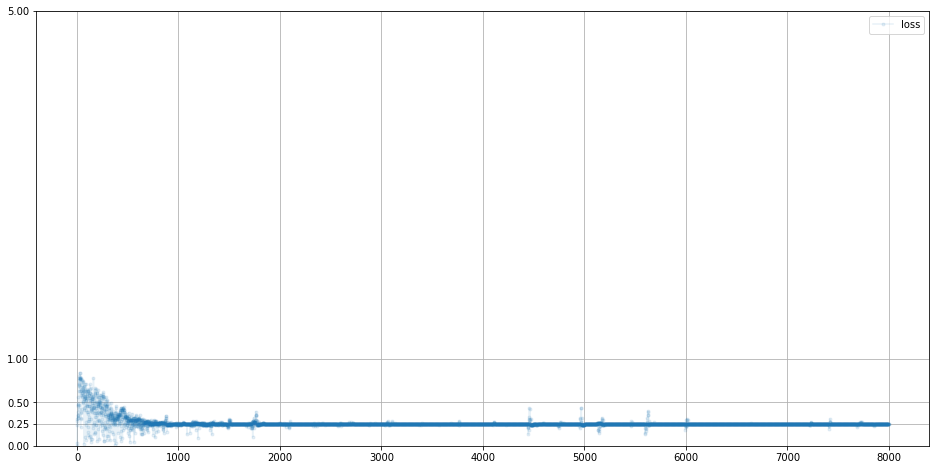

In [35]:
G.plot_progress()

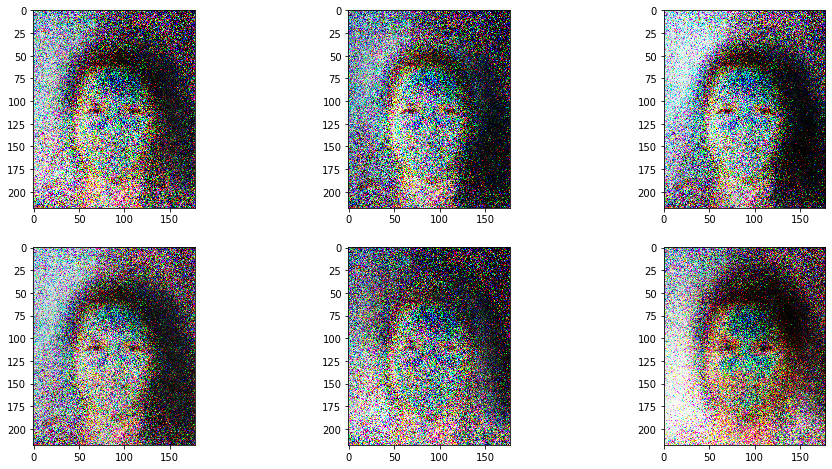

In [37]:
f, axarr = plt.subplots(2,3, figsize = (16, 8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation = 'none', cmap = 'Reds')
        pass
    pass